In [1]:
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('./input/train.csv', escapechar='\\', quoting=csv.QUOTE_NONE)
df.head(2)

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID
0,"Pete The Cat Bedtime Blues Doll, 14.5 Inch","Pete the Cat is the coolest, most popular cat ...","[Pete the Cat Bedtime Blues plush doll,Based o...",MerryMakers,0
1,"The New Yorker NYHM014 Refrigerator Magnet, 2 ...",The New Yorker Handsome Cello Wrapped Hard Mag...,[Cat In A Tea Cup by New Yorker cover artist G...,The New Yorker,1


In [3]:
test_df = pd.read_csv('./input/test.csv', escapechar='\\', quoting=csv.QUOTE_NONE)
test_df.head(2)

,PRODUCT_ID,TITLE,DESCRIPTION,BULLET_POINTS,BRAND
0,1,"Command 3M Small Kitchen Hooks, White, Decorat...",Sale Unit: PACK,[INCLUDES - 9 hooks and 12 small indoor strips...,Command
1,2,O'Neal Jump Hardware JAG Unisex-Adult Glove (B...,Synthetic leather palm with double-layer thumb...,[Silicone printing for a better grip. Long las...,O'Neal


In [4]:
len(test_df)

110775

In [5]:
len(df)

2903024

In [6]:
df.BROWSE_NODE_ID.nunique()

9919

In [6]:
df.BRAND.nunique()

258265

In [7]:
np.sum(df.isna())

TITLE                 71
DESCRIPTION       723664
BULLET_POINTS     166263
BRAND              56737
BROWSE_NODE_ID         0
dtype: int64

In [8]:
np.sum(test_df.isna())

PRODUCT_ID           0
TITLE                7
DESCRIPTION      10469
BULLET_POINTS     6786
BRAND             2430
dtype: int64

### Observations

1) As there are too many samples and the metric is also Accuracy we can remove the rows with nan values. For every row in the test set which will have all its values as NAN we will predict the most frequent class.

2) We can also make a classifier for that case using only the BRAND as input.

In [9]:
temp_df = df.copy()

In [10]:
# REMOVING ROWS WEHRE TITLE AND BRAND ARE NANs
df = temp_df.copy()
df = df.dropna(subset=['TITLE', 'BRAND'])
len(df)

2846227

<AxesSubplot:>

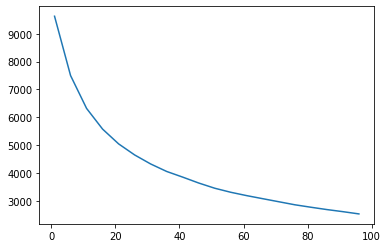

In [11]:
values = []
ranges = []
for i in range(1,100,5):
    values.append(np.sum(df.BROWSE_NODE_ID.value_counts() > i))
    ranges.append(i)
    
sns.lineplot(x=ranges, y=values)

### Observations

As there are too many classes and the metric is Accuracy we can just remove less frequent classes. The problem is to choose a good threshold.

We can have 3 sets of datasets at 3 differnt thresholds and we train 3 models using these 3 different thresholds. In each model we will have 1 extra label for out-of-class i.e. if there is one such sample that model thinks not belongs to our class then we will let the second model predict that. That way we will have diversity.

In [12]:
# The BROWSE_NODE_ID == 0 needs to be changed to a different value
df.loc[df[df['BROWSE_NODE_ID'] == 0].index, 'BROWSE_NODE_ID'] = 10000

# I am defining thresholds at 10, 30 and 110
value_counts = dict(df['BROWSE_NODE_ID'].value_counts())

df['Threshold1'] = df['BROWSE_NODE_ID'].map(lambda x: 1 if (value_counts[x] >= 10 and value_counts[x] < 30) else 0)
df['Threshold2'] = df['BROWSE_NODE_ID'].map(lambda x: 1 if (value_counts[x] >= 30 and value_counts[x] < 110) else 0)
df['Threshold3'] = df['BROWSE_NODE_ID'].map(lambda x: 1 if value_counts[x] >= 110 else 0)

In [13]:
# Now we drop all the values with value equal to zero'
df = df[np.sum(df[['Threshold1', 'Threshold2', 'Threshold3']], axis=1) != 0]
len(df)

2831443

In [14]:
# Setting up a out-of-label class
df['label1'] = df['Threshold1'].values * df['BROWSE_NODE_ID'].values
df['label2'] = df['Threshold2'].values * df['BROWSE_NODE_ID'].values
df['label3'] = df['Threshold3'].values * df['BROWSE_NODE_ID'].values

df.drop(columns=['Threshold1', 'Threshold2', 'Threshold3', 'BROWSE_NODE_ID'], inplace=True)
df.head()

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,label1,label2,label3
0,"Pete The Cat Bedtime Blues Doll, 14.5 Inch","Pete the Cat is the coolest, most popular cat ...","[Pete the Cat Bedtime Blues plush doll,Based o...",MerryMakers,0,0,10000
1,"The New Yorker NYHM014 Refrigerator Magnet, 2 ...",The New Yorker Handsome Cello Wrapped Hard Mag...,[Cat In A Tea Cup by New Yorker cover artist G...,The New Yorker,0,0,1
3,Amway Nutrilite Kids Chewable Iron Tablets (100),NaN,"[Nutrilite Kids,Chewable Iron Tablets,Quantity...",Amway,0,0,3
5,Men'S Full Sleeve Raglan T-Shirts Denim T-Shir...,Men'S Full Sleeve Raglan T-Shirts Denim T-Shir...,"[Color: Blue,Sleeve: Full Sleeve,Material: Cot...",Bhavya Enterprise,0,0,5
6,Glance Women's Wallet (Black) (LW-21),This Black wallet by Glance will be a treasure...,[The Most Comfortable Women's Wallet That You ...,Glance,0,0,6


In [15]:
df[['label1', 'label2', 'label3']].nunique()

label1    2252
label2    2074
label3    2381
dtype: int64

In [16]:
df['label1'].value_counts() # We will drop the 0 label while modelling.

0         2792067
11986          29
32059          29
2853           29
56122          29
           ...   
744996         10
564            10
262            10
531719         10
96074          10
Name: label1, Length: 2252, dtype: int64

### Observations
Now this has become much much more doable.

Let's once again look at the nan values

In [17]:
np.sum(df.isna())

TITLE                 0
DESCRIPTION      672088
BULLET_POINTS    115664
BRAND                 0
label1                0
label2                0
label3                0
dtype: int64

### Observations
There are a lot of places where `description` is `nan` and a lot where `Bullet_points` is `nan`. The crucial think to took note of that `Bullet Points` are usually derived from `description` and hence more concise and usefull for us.

Now as for how to handle these nan values. We have the following methods:
 * We can append `Title`, `Description`, `Bullet_points` to a single string. That append will be seprated by special characters in BERT, RoBERTA etc. and where there are `nan` value we just pass append the string `nan`.
 * We can use the `Title` embedding sepratelly and just append the rest 2.
 * Don't use the description at all.
 
Other ideas can also be applied.

Now coming to the spilt of the dataset. We can either use a StratifiedKFold or just the normal trian_test_split. I think we should try using both and see the difference. If there isn't much different in submission then we will just continue on the train_test_spilt else we will work on the StratifiedKFold splits.

In [18]:
# Normal train test split
from sklearn.model_selection import train_test_split, StratifiedKFold

train_idx1, valid_idx1 = train_test_split(df.index, stratify=df['label1'], random_state=1234)
train_idx2, valid_idx2 = train_test_split(df.index, stratify=df['label2'], random_state=1234)
train_idx3, valid_idx3 = train_test_split(df.index, stratify=df['label3'], random_state=1234)

df['split1'] = -1
df['split2'] = -1
df['split3'] = -1

df.loc[train_idx1, 'split1'] = 'train'
df.loc[valid_idx1, 'split1'] = 'valid'

df.loc[train_idx2, 'split2'] = 'train'
df.loc[valid_idx2, 'split2'] = 'valid'

df.loc[train_idx3, 'split3'] = 'train'
df.loc[valid_idx3, 'split3'] = 'valid'

In [19]:
# KFold split - 5 Folds
df = df.sample(frac=1, random_state=1234).reset_index(drop=True)
splitter = StratifiedKFold(n_splits=5)

df['kfold1'] = -1
df['kfold2'] = -1
df['kfold3'] = -1

for fold, (trn, val) in enumerate(splitter.split(df.index, df.label1)):
    df.loc[val, 'kfold1'] = fold
    
for fold, (trn, val) in enumerate(splitter.split(df.index, df.label2)):
    df.loc[val, 'kfold2'] = fold
    
for fold, (trn, val) in enumerate(splitter.split(df.index, df.label3)):
    df.loc[val, 'kfold3'] = fold

### Saving the new dataframe

For now I am saving the new dataframe. This df will be used for further preprocessing of the dataset. Also, I am temperary filling the `nan` values as a str:nan

In [20]:
df.fillna('nan', inplace=True)

In [21]:
df.to_csv('./input/new_train.csv', index=False)

### Getting the length of description

In [22]:
df['len_des'] = df['DESCRIPTION'].map(lambda x: len(str(x)))

<AxesSubplot:xlabel='len_des', ylabel='Density'>

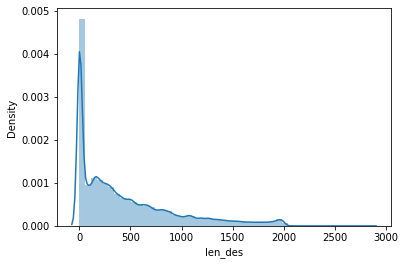

In [23]:
sns.distplot(df['len_des'])

In [40]:
df['len_bullet'] = df['BULLET_POINTS'][:10].map(lambda x: len(str(x[1:-1])))

<AxesSubplot:xlabel='len_bullet', ylabel='Density'>

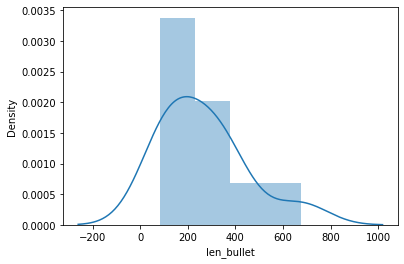

In [41]:
sns.distplot(df['len_bullet'])